# Getting Principal Components

In [2]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import pca, align


topology_file = "/home/uni/bioemu/2k39-bioemu-200-samples/PDBs/topology-1200-odd-atoms.pdb"
trajectory_file = "/home/uni/bioemu/2k39-bioemu-200-samples/PDBs/visualization-1200-odd-atoms/combined-samples-trajectory.pdb"
u = mda.Universe(topology_file, trajectory_file)
n_pc = None # number of principal components to compute; None means all components

# Align the trajectory to the first frame using the backbone atoms. This is necessary for PCA to ensure that the analysis is not affected by translational and rotational motion and to focus on the conformational changes of the protein.
aligner = align.AlignTraj(u, u, select='backbone', in_memory=True).run()

pca_analysis = pca.PCA(u, select='backbone', align=True, mean=None, n_components=n_pc).run()

backbone = u.select_atoms('backbone')
bb_count = len(backbone)
print(f"Number of backbone atoms: {bb_count}")
print(pca_analysis.p_components.shape)

# variance of each component
for i, variance in enumerate(pca_analysis.variance):
    print(f"Variance {i+1}: {variance}")

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='MDAnalysis') # looks like biopython, a dependency has some sort of deprecation; uncomment this line to find out 

FileNotFoundError: [Errno 2] No such file or directory: '/home/uni/bioemu/2k39-bioemu-200-samples/PDBs/visualization-1200-odd-atoms/combined-samples-trajectory.pdb'

### Plotting Eigenvectors vs Eigenvalues

/home/uni/miniconda3/lib/python3.13/site-packages/MDAnalysis/analysis/pca.py:370: DeprecationWarning: The `cumulated_variance` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.cumulated_variance` instead.
  warnings.warn(wmsg, DeprecationWarning)


Text(0, 0.5, 'Cumulative variance [Eigenvalue]')

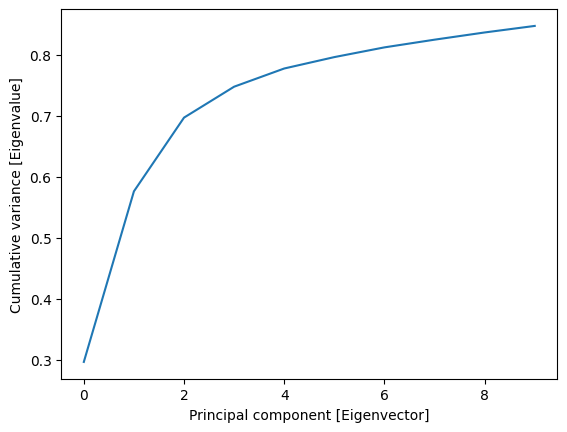

In [ ]:
import matplotlib.pyplot as mplt
mplt.plot(pca_analysis.cumulated_variance[:10])
mplt.xlabel('Principal component [Eigenvector]')
mplt.ylabel('Cumulative variance [Eigenvalue]')
# mplt.show()  # uncomment to show the plot in a non interactive environment

# Reduced-dimension visualization

### Computing weights

In [ ]:
# converting backbone (an atomgroup) into eigenvector (here principal component) based weight. Here the weight is the eigenvector itself scaled by the signed deviation of the coordinate from the mean (where mean could be the the coordinate of the centroid structure of the average of the all the frames coordinates for that atom):

transformed = pca_analysis.transform(backbone,n_components=3) # transformed is weights of atomgroups projected onto a principal component; each principal component gets its own set of weights for a given atomgroup
print(transformed.shape) # (n_frames, n_components)


(194, 3)


### Dataframe-ing it

In [ ]:
# Now, for easy handling, we can convert the transformed to a pandas DataFrame
import pandas as pd
df = pd.DataFrame(transformed, columns=['PC{}'.format(i+1) for i in range(3)])
df['Time (ps)'] = df.index * u.trajectory.dt
# print(df.head())
# Save the transformed to a CSV file for further analysis
df.to_csv('pca_transformed.csv', index=False)

"""print(df.index)
print(df.index * u.trajectory.dt)
print(u.trajectory.dt)
print(df.head())"""

'print(df.index)\nprint(df.index * u.trajectory.dt)\nprint(u.trajectory.dt)\nprint(df.head())'

### Visualization

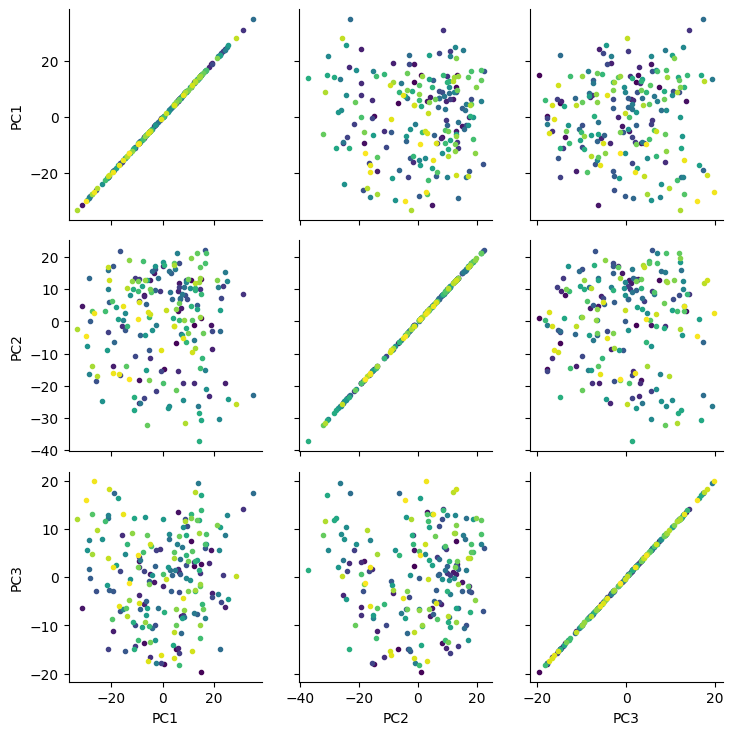

In [ ]:
import seaborn as sbn

pg = sbn.PairGrid(df, hue='Time (ps)', palette=sbn.color_palette("viridis", n_colors=len(df)))
pg.map(mplt.scatter, marker='.',)
#mplt.show()  # uncomment to show the plot in a non interactive environment
# Save the pair grid plot
pg.savefig('pair_grid_plot.png')


# Projecting the original trajectory onto principal components

### Analysis

Take the outer product, load it in a new universe of just backbone. 

As an intermediary, you would need to reshape the result of the outer product to load them as coordinates in a new universe (with 1 atomgroup: backbone)

In [ ]:
# Projecting the original trajectory onto the first principal component
pc1 = pca_analysis.p_components[:, 0] # all rows, and first column
transformed1 = transformed[:, 0] # all rows, and first column

import numpy
projected = numpy.outer(transformed1, pc1) + pca_analysis.mean.flatten() # flatten takes the mean coordinates from multi dimensional arrays to single dimension array 
n_frames = u.trajectory.n_frames  # number of frames in the trajectory
n_atoms = len(backbone)  # number of atoms in the backbone selection
coordinates = projected.reshape(n_frames, n_atoms, 3)
# -1 means the value there is determined based on the other two and the total number of elements. So, while the first and the last argument are given, the second dimension is asked to be determined. Here the second argument is number of atoms I think as indicated by order the a in fac in the next cell. so the reshaped dimensions represent number of principal components, number of atoms and the three spatial axes (x, y and z), responectively.
print(coordinates)
print(pc1.shape)  # Should be (n_atoms*3,)
print(coordinates.shape)  # Should be (n_frames, n_atoms, 3)
print(len(backbone))  # Should be n_atoms
proj_pc1 = mda.Merge(backbone) # creating new universe object with just backbone atoms
proj_pc1.load_new(coordinates, order='fac') # fac: f for fortran order, a for atom index, c for coordinates


/home/uni/miniconda3/lib/python3.13/site-packages/MDAnalysis/analysis/pca.py:350: DeprecationWarning: The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.
  warnings.warn(wmsg, DeprecationWarning)


[[[  8.10303999   1.1991559   11.54892242]
  [  6.77474328   1.50093712  11.97861431]
  [  5.77827211   0.52107194  11.40012261]
  ...
  [ -8.47217578  -6.47557308 -17.30697103]
  [ -8.42935549  -6.7506143  -17.44640094]
  [ -8.32306051  -6.79710997 -17.34797534]]]
(912,)
(1, 58976, 3)
304


ValueError: The provided value for n_atoms (304) does not match the shape of the coordinate array (58976)

### interactive visualization

In [ ]:
import nglview as ngl

view = ngl.show_mdanalysis(proj_pc1.atoms)
view

from nglview.contrib.movie import MovieMaker
movie = MovieMaker(
    view,
    step=4,  # keep every 4th frame
    output='pc1.gif',
    render_params={"factor": 3},  # set to 4 for highest quality
)
movie.make()


# Cosine Component

In [ ]:
# cosine component of each principal component
for i in range(3):
    cosine_content = pca.cosine_content(transformed, i)
    print(f"Cosine content for PC{i+1} = {cosine_content:.3f}")

In [ ]:
# data processing: melt the dataframe into a tidy format
melted = pd.melt(df, id_vars=["Time (ps)"], var_name="PC", value_name="Value")


# visualization
# Plot the metled dataframe to see the cosine form of each principal component
g = sbn.FacetGrid(melted, col="PC")
g.map(sbn.lineplot,
      "Time (ps)", # x-axis
      "Value", # y-axis
      ci=None) # No confidence interval
# mplt.show() # uncomment to show the plot in non interactive environments